# Statistical Analysis - Linear Regression

Dans ce projet, j'analyserai les données historiques de promotions marketing d'une petite entreprise. Chaque ligne correspond à une promotion marketing indépendante au cours de laquelle l'entreprise a utilisé la télévision, les médias sociaux, la radio et des promotions d'influenceurs pour augmenter ses ventes.

L'objectif de l'entreprise est de déterminer quelle caractéristique influence le plus fortement les ventes, afin de mieux comprendre sur quel type de promotion investir à l'avenir. Pour atteindre cet objectif, je construirai un modèle de régression linéaire en utilisant la méthode des moindres carrés ordinaires (OLS).

Ce projet inclura notamment les étapes suivantes :

* L'exploration et le nettoyage des données
* L'utilisation de graphiques et de statistiques descriptives pour sélectionner les variables indépendantes
* Création d'un modèle de régression linéaire adapté
* Vérification des hypothèses du modèle
* Interprétation des résultats du modèle et communication des résultats aux parties prenantes non techniques.

# Part 1: Simple Linear Regression

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import seaborn as sns
import scipy.stats
import numpy as np
import math

## Exploration du Data

Avant de construire un modèle de régression linéaire, nous devons :
* Comprendre quelles variables sont présentes dans les données.
* Examiner la distribution des caractéristiques, telles que les valeurs minimales, moyennes et maximales.
* Tracer la relation entre les variables indépendantes et dépendantes pour visualiser les caractéristiques qui ont une relation linéaire.
* Identifier les problèmes liés aux données, tels que les valeurs incorrectes (par exemple, les fautes de frappe) ou les valeurs manquantes.

In [26]:
data = pd.read_csv('dummy-advertising-and-sales-data/Dummy Data HSS.csv')
data.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


Les caractéristiques des données sont les suivantes:

Budget de promotion à la télévision 'TV' (en millions de dollars)

Budget de promotion dans les médias sociaux 'Social Media' (en millions de dollars)

Budget de promotion à la radio 'Radio' (en millions de dollars)

Ventes 'Sales' (en millions de dollars)

In [21]:
data.shape

(4546, 5)

### Explorer les variables

In [24]:
data.drop('Sales', axis=1).describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TV,4546.0,NaN,NaN,NaN,54.062912,26.104942,10.0,32.0,53.0,77.0,100.0
Radio,4546.0,NaN,NaN,NaN,18.157533,9.66326,0.000684,10.555355,17.859513,25.640603,48.871161
Social Media,4546.0,NaN,NaN,NaN,3.323473,2.211254,0.000031,1.530822,3.055565,4.804919,13.981662
Influencer,4546,4,Mega,1152,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Avant d'ajuster le modèle, nous devons assurer que les ventes 'Sales' de chaque promotion (c'est-à-dire de chaque ligne) sont présentes. Si les ventes d'une ligne sont manquantes, cette ligne n'a pas beaucoup de valeur pour le modèle de régression linéaire

In [9]:
data.isnull().sum()

TV              10
Radio            4
Social Media     6
Influencer       0
Sales            6
dtype: int64

In [27]:
data = data.dropna(axis=0)

### Visualiser la distribution des ventes

Text(0.5, 1.0, 'Distribution des ventes')

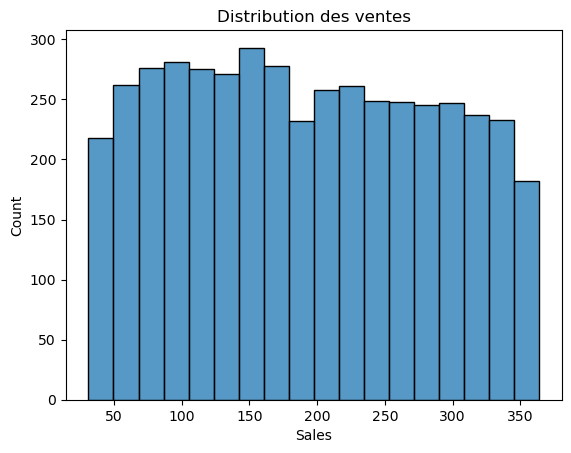

In [11]:
fig = sns.histplot(data.Sales)
fig.set_title('Distribution des ventes')

En général, les ventes sont réparties de manière égale entre 25 et 350 millions.

#### Calculer la moyenne des ventes pour la variable catégorielle 'Influencer'

In [12]:
print(data.groupby('Influencer').Sales.mean())

Influencer
Macro    196.066150
Mega     190.412908
Micro    191.578370
Nano     191.708827
Name: Sales, dtype: float64


## Construction de modèle

Créer un diagramme à paires pour visualiser les relations entre les paires de variables dans les données. je l'utilise pour déterminer visuellement quelle variable a la relation linéaire la plus forte avec les ventes 'Sales'. Cela m'aidera à sélectionner la variable X pour la régression linéaire.

C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


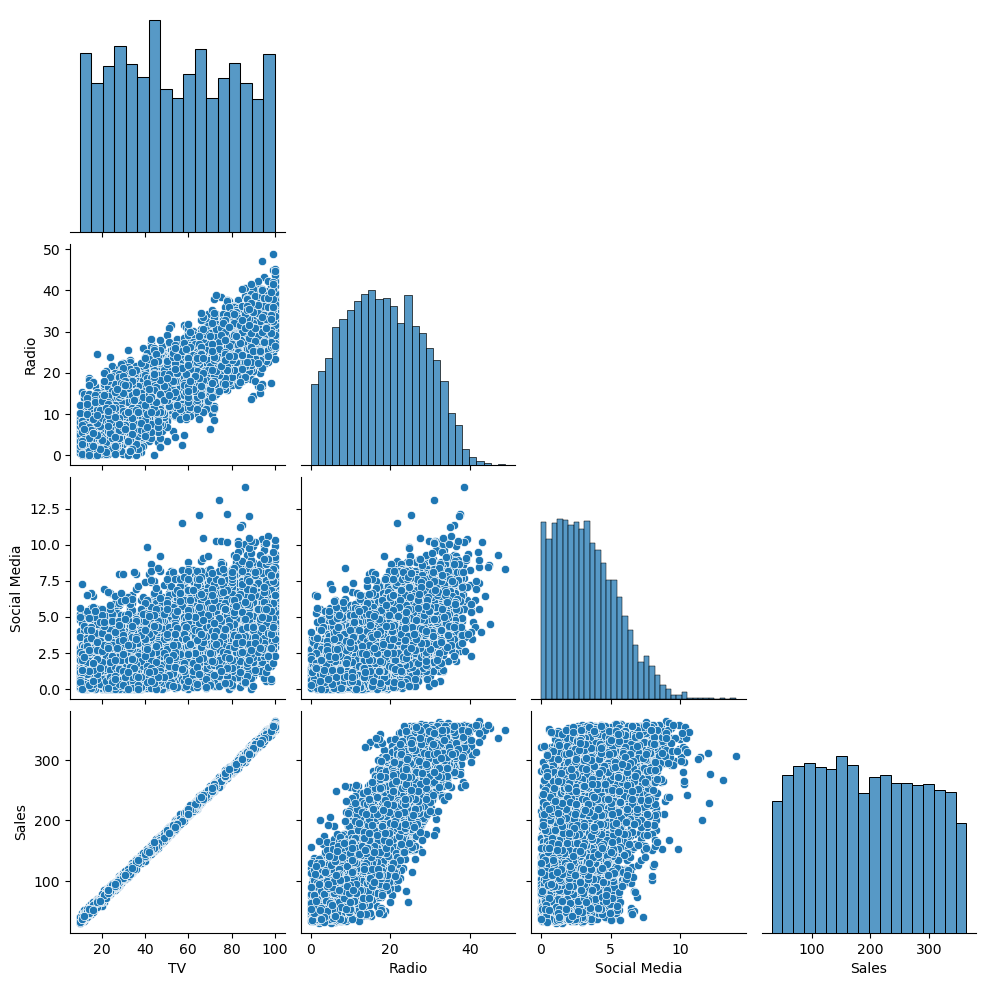

In [13]:
sns.pairplot(data, corner=True)

'TV' présente clairement la relation linéaire la plus forte avec les ventes (Sales). Aussi, 'Radio' semble avoir une relation linéaire avec 'Sales'.

A ce stade, je choissie 'TV' et 'Radio' comme des varibles indépendntes pour le modéle:  

### Vérifier les hypothèses du modèle de régression linéaire

#### 1- Linéarité

Est déja vérifié par le diagramme à paires précédent entre les variables indépendantes 'TV' et 'Radio' et la variable dépendante 'Sales'

#### 2- Indépendance

L'hypothèse d'observation indépendante stipule que chaque observation de l'ensemble de données est indépendante. Comme chaque promotion commerciale (c'est-à-dire chaque ligne) est indépendante les unes des autres, l'hypothèse d'indépendance n'est pas violée.

#### 3- colinéarité multiple

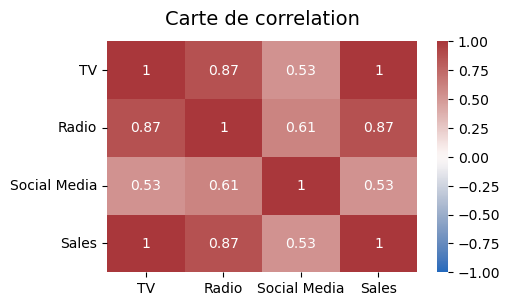

In [14]:
plt.figure(figsize=(5, 3))
heatmap = sns.heatmap(data.drop('Influencer', axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Carte de correlation', fontdict={'fontsize':14}, pad=12)
plt.show()

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data[['Radio','TV']]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
df_vif = pd.DataFrame(vif, index=X.columns, columns = ['VIF'])
df_vif

,VIF
Radio,18.439962
TV,18.439962


Suite à l'observation du diagramme à paires et de VIF précédents, il est évident qu'une corrélation significative existe entre les deux variables indépendantes, 'TV' et 'Radio', suggérant une possible violation de l'hypothèse d'indépendance des variables. Afin de remédier à cette situation, j'ai décidé de choisir uniquement la variable 'TV' qui présente une corrélation plus marquée avec la variable 'Sales'. Cette sélection est basée sur le principe de privilégier la variable qui démontre la relation la plus forte avec la variable dépendante 'Sales

### Construire et entrainer le modèle

In [17]:
ols_formula = 'Sales ~ TV'
OLS = ols(formula=ols_formula, data=data)
model = OLS.fit()
model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.517e+06
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:51:21   Log-Likelihood:                -11366.
No. Observations:                4546   AIC:                         2.274e+04
Df Residuals:                    4544   BIC:                         2.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1325      0.101     -1.317      0.188      -0.330       0.065
TV             3.5615      0.002   2125.272      0.000       3.558       3.565
==============================================================================
Omnibus:                        0.052   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.974   Jarque-Bera (JB):                0.031
Skew:                          -0.001   Prob(JB):                        0.985
Kurtosis:                       3.012   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Vérifier les hypothèses du modèle de régression linéaire: Suite

#### 4- Normalité

L'hypothèse de **normalité** indique que les erreurs sont normalement distribuées.

Créez deux graphiques pour vérifier cette hypothèse :

* Histogramme des résidus
* Graphique Q-Q des résidus

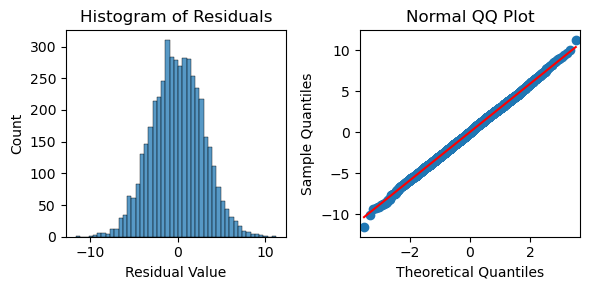

In [18]:
residuals = model.resid
fig, axes = plt.subplots(1, 2, figsize = (6,3))
sns.histplot(residuals, ax=axes[0])
axes[0].set_xlabel("Residual Value")
axes[0].set_title("Histogram of Residuals")
sm.qqplot(residuals, line='s',ax = axes[1])
axes[1].set_title("Normal QQ Plot")
plt.tight_layout()
plt.show();

L'histogramme des résidus est approximativement distribué normalement, ce qui confirme que l'hypothèse de normalité est respectée pour ce modèle. Les résidus dans le graphique Q-Q forment une ligne droite, ce qui confirme que cette hypothèse est respectée.

#### 5- Homoscédasticité

L'hypothèse d'homoscédasticité (variance constante) est que les résidus ont une variance constante pour toutes les valeurs de X.

Vérifier que cette hypothèse n'est pas violée en créant un nuage de points avec les valeurs ajustées et les résidus. Ajouter une ligne à 𝑦=0 pour visualiser la variance des résidus au-dessus et au-dessous de 𝑦=0.

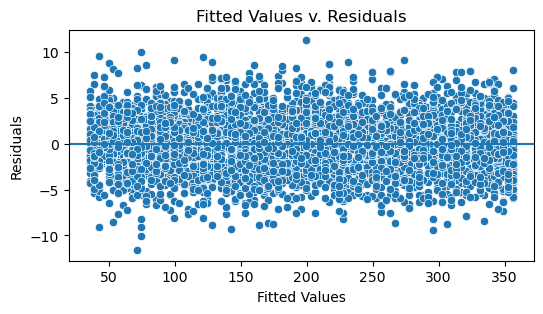

In [19]:
plt.figure(figsize=(6, 3))
fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("Fitted Values v. Residuals")
fig.axhline(0)
plt.show()

La variance des résidus est constante pour tous les 𝑋 . L'hypothèse d'homoscédasticité est donc respectée.

## Résultats et évaluation

In [20]:
model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.517e+06
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:51:21   Log-Likelihood:                -11366.
No. Observations:                4546   AIC:                         2.274e+04
Df Residuals:                    4544   BIC:                         2.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1325      0.101     -1.317      0.188      -0.330       0.065
TV             3.5615      0.002   2125.272      0.000       3.558       3.565
==============================================================================
Omnibus:                        0.052   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.974   Jarque-Bera (JB):                0.031
Skew:                          -0.001   Prob(JB):                        0.985
Kurtosis:                       3.012   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

En utilisant la télévision comme X, on obtient un modèle de régression linéaire simple avec $R^{2} = 0,999$. En d'autres termes, "TV" explique $99,9 %$ de la variation des ventes.

### Interpréter les résultats du modèle

Lorsque TV est utilisée comme variable indépendante X, l'équation linéaire est:

Sales = −0.1325 + 3.5615 ∗ TV

Selon le modèle, lorsque la télévision est utilisée comme variable indépendante X, une augmentation d'un million de dollars du budget promotionnel de la télévision se traduit par une augmentation des ventes estimée à 3.5614 millions de dollars.

### Mesurer l'incertitude des estimations des coefficients

Les coefficients du modèle sont estimés. Cela signifie que l'estimation comporte une part d'incertitude. P-value et un intervalle de confiance à 95 sont fournis avec chaque coefficient pour quantifier l'incertitude de l'estimation de ces coefficients.

In [21]:
model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.517e+06
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:51:21   Log-Likelihood:                -11366.
No. Observations:                4546   AIC:                         2.274e+04
Df Residuals:                    4544   BIC:                         2.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1325      0.101     -1.317      0.188      -0.330       0.065
TV             3.5615      0.002   2125.272      0.000       3.558       3.565
==============================================================================
Omnibus:                        0.052   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.974   Jarque-Bera (JB):                0.031
Skew:                          -0.001   Prob(JB):                        0.985
Kurtosis:                       3.012   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lorsque `TV` est utilisé comme variable indépendante, il a une valeur p de $0.000$ et un intervalle de confiance de $95\%$ de $[3.558,3.565]$. Cela signifie qu'il y a 95 % de chances que l'intervalle $[3.558,3.565]$ contienne la vraie valeur du paramètre de la pente. Ces résultats indiquent qu'il y a peu d'incertitude dans l'estimation de la pente de X. Par conséquent, l'entreprise peut avoir confiance dans l'impact de la "TV" sur les "ventes".

## Conclusion

* Parmi la télévision, les médias sociaux et la radio, c'est la télévision qui présente la relation linéaire positive la plus forte avec les ventes. 
* Le modèle de régression linéaire estime que 99,9 % de la variation des ventes est expliquée par le budget promotionnel de la télévision. En d'autres termes, la quasi-totalité de la variation des ventes peut être expliquée par le seul budget promotionnel de la télévision, ce qui fait de la télévision un excellent prédicteur des ventes.
* Selon le modèle, lorsque la télévision est utilisée comme variable indépendante X, une augmentation d'un million de dollars du budget promotionnel de la télévision se traduirait par une augmentation des ventes estimée à 3,5614 millions de dollars. 
* L'intervalle (3,558 millions, 3,565 millions) a une probabilité de 95% de contenir la véritable estimation de l'augmentation des ventes pour une augmentation d'un million de dollars du budget promotionnel de la télévision. Par conséquent, l'estimation fournie au point précédent est très fiable.

# Part 2: Multiple linear regression

In [28]:
bin_edges = [0, 33.34, 66.67, 101]
bin_labels = ['Low', 'Medium', 'High']
data.loc[:, 'TV'] = pd.cut(data['TV'], bins=bin_edges, labels=bin_labels, right=False)
data.head()

,TV,Radio,Social Media,Influencer,Sales
0,Low,6.566231,2.907983,Mega,54.732757
1,Low,9.237765,2.409567,Mega,46.677897
2,Medium,15.886446,2.913410,Mega,150.177829
3,High,30.020028,6.922304,Mega,298.246340
4,Low,8.437408,1.405998,Micro,56.594181


Créer un diagramme à paires pour visualiser la relation entre les variables continues dans les données.

C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


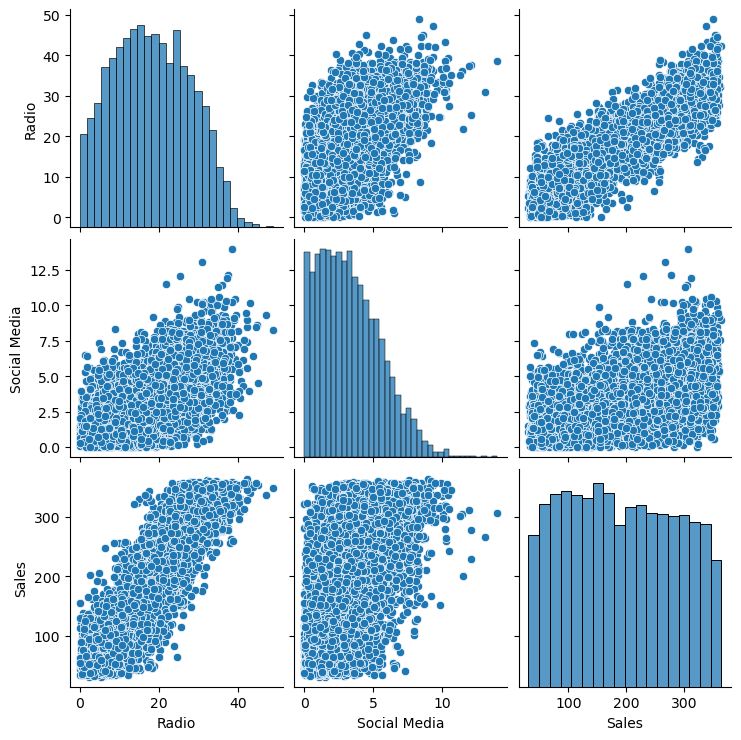

In [29]:
sns.pairplot(data);

La radio et les médias sociaux semblent tous deux avoir une relation linéaire avec les ventes. Par conséquent, la radio et les médias sociaux peuvent être utiles en tant que variables indépendantes dans un modèle de régression linéaire multiple estimant les ventes.

### Calculate the mean sales for each categorical variable

In [30]:
print(data.groupby('TV')['Sales'].mean())
print('')
print(data.groupby('Influencer')['Sales'].mean())

TV
Low        77.049254
Medium    176.803671
High      297.676539
Name: Sales, dtype: float64

Influencer
Macro    196.066150
Mega     190.412908
Micro    191.578370
Nano     191.708827
Name: Sales, dtype: float64


Le moyen de 'Sales' de " High TV " est considérablement plus élevé que celui des promotions à " Medium TV " et " Low TV ". La `TV` peut être un facteur prédictif important des `ventes`.

Les catégories pour `Influenceur` ont des moyennes de `Sales` différentes, mais la variation n'est pas substantielle. L'indicateur `Influenceur` peut être une faible variable prédictive des `Sales`.

## Vérifier les hypothèses du modèle de régression linéaire

#### 1- Linéarité

Text(0.5, 1.0, 'Radio and Sales')

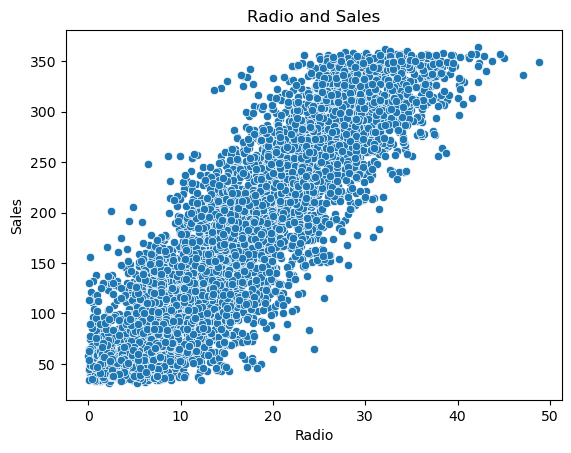

In [32]:
fig = sns.scatterplot(x = data['Radio'], y = data['Sales'])
fig.set_title("Radio and Sales")

#### 2- Indépendance

L'hypothèse d'observation indépendante stipule que chaque observation de l'ensemble de données est indépendante. Comme chaque promotion commerciale (c'est-à-dire chaque ligne) est indépendante les unes des autres, l'hypothèse d'indépendance n'est pas violée.

## Construction de modèle

In [33]:
ols_formula = 'Sales ~ C(TV) + Radio'
OLS = ols(formula = ols_formula, data = data)
model = OLS.fit()
model_results = model.summary()
model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 1.592e+04
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:00:53   Log-Likelihood:                -21502.
No. Observations:                4546   AIC:                         4.301e+04
Df Residuals:                    4542   BIC:                         4.304e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          52.4515      0.974     53.873      0.000      50.543      54.360
C(TV)[T.Medium]    74.2895      1.188     62.534      0.000      71.960      76.618
C(TV)[T.High]     160.3908      1.761     91.071      0.000     156.938     163.844
Radio               3.0526      0.072     42.363      0.000       2.911       3.194
==============================================================================
Omnibus:                      102.196   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.917
Skew:                           0.031   Prob(JB):                     1.96e-12
Kurtosis:                       2.470   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Vérifier les hypothèses du modèle de régression linéaire: Suite

#### 4- Normalité

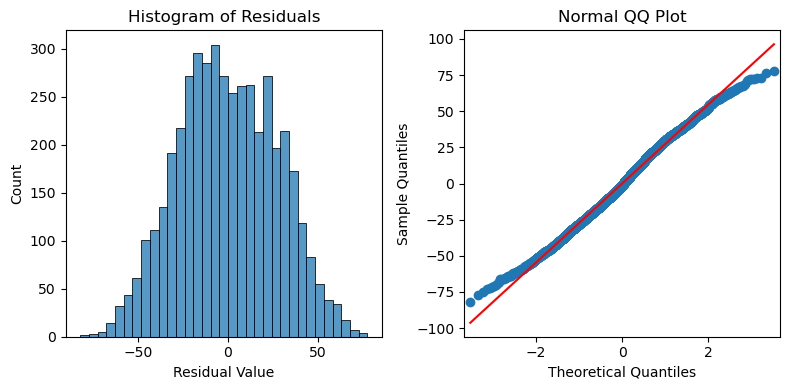

In [34]:
residuals = model.resid
fig, axes = plt.subplots(1, 2, figsize = (8,4))
sns.histplot(residuals, ax=axes[0])
axes[0].set_xlabel("Residual Value")
axes[0].set_title("Histogram of Residuals")
sm.qqplot(residuals, line='s',ax = axes[1])
axes[1].set_title("Normal QQ Plot")
plt.tight_layout()
plt.show()

L'histogramme des résidus est approximativement distribué normalement, ce qui confirme que l'hypothèse de normalité est respectée pour ce modèle. Les résidus dans le graphique Q-Q forment une ligne droite, ce qui confirme que cette hypothèse est respectée.

#### 5- Homoscédasticité

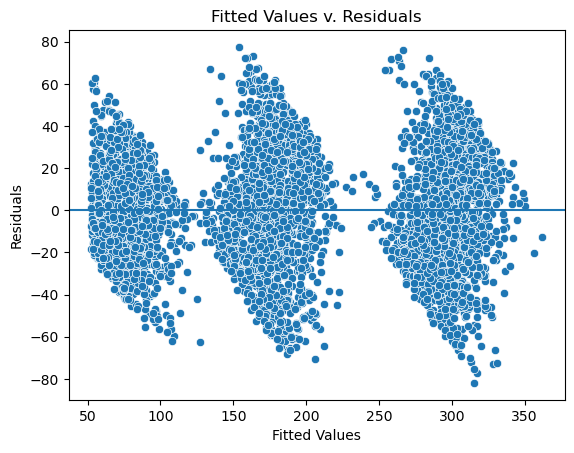

In [35]:
fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("Fitted Values v. Residuals")
fig.axhline(0)
plt.show()

Les valeurs ajustées sont réparties en trois groupes car la variable catégorielle est dominante dans ce modèle, ce qui signifie que la télévision est le facteur le plus important qui détermine les ventes.

Cependant, la variance où il y a des valeurs ajustées est distribuée de façon similaire, ce qui valide que l'hypothèse est respectée.

## Résultats et évaluation

In [36]:
model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 1.592e+04
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:00:53   Log-Likelihood:                -21502.
No. Observations:                4546   AIC:                         4.301e+04
Df Residuals:                    4542   BIC:                         4.304e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          52.4515      0.974     53.873      0.000      50.543      54.360
C(TV)[T.Medium]    74.2895      1.188     62.534      0.000      71.960      76.618
C(TV)[T.High]     160.3908      1.761     91.071      0.000     156.938     163.844
Radio               3.0526      0.072     42.363      0.000       2.911       3.194
==============================================================================
Omnibus:                      102.196   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.917
Skew:                           0.031   Prob(JB):                     1.96e-12
Kurtosis:                       2.470   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

En utilisant "TV" et "Radio" comme variables indépendantes, on obtient un modèle de régression linéaire multiple avec 𝑅2=0,913
 . En d'autres termes, le modèle explique 91,3 % de la variation des ventes. Le modèle est donc un excellent prédicteur des ventes.

### Interpreter les coefficients du modèle

Lorsque `TV` et `Radio` sont utilisés pour prédire `Sales`, les coefficients du modèle sont :

* $\beta_{0} =  52.4515$
* $\beta_{TVHigh}= 160.3908$
* $\beta_{TVMedium} = 74.2895$
* $\beta_{Radio} =  3.0526$

La relation entre "Sales" et les variables indépendantes sous forme d'équation linéaire est la suivante :


$\text{Sales} = \beta_{0} + \beta_{1}*X_{1}+ \beta_{2}*X_{2}+ \beta_{3}*X_{3}$

$\text{Sales} = \beta_{0} + \beta_{TVLow}*X_{TVLow}+ \beta_{TVMedium}*X_{TVMedium}+ \beta_{Radio}*X_{Radio}$

$\text{Sales} = 52.4515 + 160.3908*X_{TVHigh} + 74.2895*X_{TVMedium}+ 3.0526 *X_{Radio}$

La catégorie `TV` par défaut du modèle est `Low` puisqu'il existe des coefficients pour les deux autres catégories `TV`, `Medium` et `High`.

Le modèle prédit qu'une promotion `High` `TV` est en moyenne 160.3908 plus élevée qu'une promotion `Low` `TV` pour la même promotion `Radio`.

Le coefficient de `Radio` est positif, ce qui confirme la relation linéaire positive démontrée précédemment lors de l'analyse exploratoire des données.

La valeur $p$ pour tous les coefficients est de $0,000$, ce qui signifie que tous les coefficients sont statistiquement significatifs à p=0,05. 

Il y a 95 % de chances que l'intervalle $[71.960, 76.618]$ contienne le véritable paramètre de la pente de $\beta_{TVMedium}$, qui est la différence estimée dans les ventes promotionnelles lorsqu'une promotion ``Medium` `TV`` est choisie au lieu d'une promotion ``Faible` `TV``.

Compte tenu de la précision de la télévision en tant qu'indicateur prévisionnel, le modèle pourrait être amélioré en obtenant une vue plus granulaire des promotions télévisées, par exemple en prenant en compte davantage de catégories ou les budgets promotionnels télévisés réels.

En outre, des variables supplémentaires, telles que le lieu de la campagne de marketing ou la période de l'année, pourraient accroître la précision du modèle.

## Conclusion

D'après le modèle, les budgets promotionnels "High TV" se traduisent par des ventes nettement plus importantes que les budgets promotionnels Medium TV et Low TV. Par exemple, le modèle prédit qu'une promotion High TV est en moyenne 160,3908 plus élevée qu'une promotion "Low TV pour une même promotion "radio".

Le coefficient pour la radio est positif, ce qui confirme la relation linéaire positive démontrée précédemment lors de l'analyse exploratoire des données.

La valeur p pour tous les coefficients est de 0,000, ce qui signifie que tous les coefficients sont statistiquement significatifs à 0,05.

Il y a 95 % de chances que l'intervalle [71,960;76,618] contienne le véritable paramètre de la pente de 𝛽𝑇𝑉𝑀𝑒𝑑𝑖𝑢𝑚, qui est la différence estimée dans les ventes promotionnelles lorsqu'une promotion télévisée moyenne est choisie au lieu d'une promotion télévisée faible.





Les budgets promotionnels "High TV" ont une influence positive substantielle sur les ventes. Le modèle estime qu'une augmentation d'un million de dollars du budget promotionnel à la radio se traduira par une augmentation des ventes de 3,0526 millions de dollars (IC à 95 % : [2,911, 3,194]).

Il est donc recommandé à l'entreprise d'allouer un budget promotionnel élevé à la télévision lorsque cela est possible et d'investir dans des promotions à la radio pour augmenter les ventes. 